In [68]:
#Importing the neccesary packages: Numpy
import numpy as np
import pandas as pd

#Matplotlib packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#NLTK Packages
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer 

#Sklearn Packages
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Imblearn Packages
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

#String Packages
import re
import string

#Word Cloud Packages
from wordcloud import WordCloud
from PIL import Image
from textblob import TextBlob

#Instantiating NLTK Stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing and Concatonating the Data

In [55]:
harvey = pd.read_csv('harvey.tsv', sep='\t')
irma = pd.read_csv('irma.tsv', sep='\t')
matthew = pd.read_csv('matthew.tsv', sep='\t')
maria = pd.read_csv('maria.tsv', sep='\t')
twint = pd.read_csv('twint.csv')

In [60]:
#Checking for Null values
canes = [harvey, irma, matthew, maria, twint]
for i in canes:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6378 entries, 0 to 6377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     6378 non-null   int64 
 1   tweet_text   6378 non-null   object
 2   class_label  6378 non-null   object
dtypes: int64(1), object(2)
memory usage: 149.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6579 entries, 0 to 6578
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     6579 non-null   int64 
 1   tweet_text   6579 non-null   object
 2   class_label  6579 non-null   object
dtypes: int64(1), object(2)
memory usage: 154.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     1157 non-null   int64 
 1   tweet_text   1157 non-null   o

In [6]:
#Checking the distribution of Target classes
maria['class_label'].value_counts()

rescue_volunteering_or_donation_effort    1384
other_relevant_information                1097
infrastructure_and_utility_damage          999
requests_or_urgent_needs                   498
sympathy_and_support                       470
injured_or_dead_people                     211
not_humanitarian                           189
caution_and_advice                         154
displaced_people_and_evacuations            92
Name: class_label, dtype: int64

In [9]:
#relief = displaced_people_and_evacuations, rescue_volunteering_or_donation_effort, caution_and_advice
#danger = injured_or_dead_people, infrastructure_and_utility_damage
#emergencies = requests_or_urgent_needs

In [10]:
for i in maria[maria['class_label'] == 'caution_and_advice']['tweet_text']:
    print(i)

Hurricane Maria Live Updates: Catastrophic Flooding in Puerto Rico by THE NEW YORK TIMES via NYT
Currently affected by a power outage? Be sure to follow these steps to ensure maximum safety of food products. #HurricaneMaria
Hurricane Maria: Storm lashes Dominican Republic after Puerto Rico #mari
Flash Flooding Threatens Towns Devastated by Hurricane Maria. #Weather #PuertoRico:  via @YouTube
Our #Americares emergency response teams on the ground for #HurricaneHarvey #HurricaneIrma #HurricaneMaria ὏7Texas➡️⬅️
RT @CBSNewYork: Hurricane Maria regains strength back to Category 3 storm after leaving path of destruction in Puerto Rico
If only there was *someone* that could do something. Something so simple, that would direct emergency services their way
RT @KatieWallsWSB: Tropical storm force winds extend 200 miles from the center of #Maria; hence the Tropical Storm Watch issued for NC http
#maria #Preparedness #Carolina #Georgia #eastcoast #Weather #orwx #pdxtst #nwinfo East Coast Residents

In [63]:
#Creating dataframe hurricanes, concatonating all the previous dataframes together
hurricanes = pd.concat(canes)

In [64]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19240 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet_id     19208 non-null  float64
 1   tweet_text   19240 non-null  object 
 2   class_label  19240 non-null  object 
dtypes: float64(1), object(2)
memory usage: 601.2+ KB


In [65]:
hurricanes['class_label'].value_counts()

rescue_volunteering_or_donation_effort    4701
other_relevant_information                4214
infrastructure_and_utility_damage         3293
sympathy_and_support                      1587
injured_or_dead_people                    1482
displaced_people_and_evacuations          1129
caution_and_advice                         987
not_humanitarian                           959
requests_or_urgent_needs                   856
emergency                                   32
Name: class_label, dtype: int64

# Data Cleaning

In [66]:
#There are too many target classes for my ideal model
#I will merge these nine targets down to four
hurricanes['class_label'] = hurricanes['class_label'].replace({'displaced_people_and_evacuations': 'relief'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'rescue_volunteering_or_donation_effort': 'relief'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'caution_and_advice': 'danger'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'injured_or_dead_people': 'danger'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'infrastructure_and_utility_damage': 'danger'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'requests_or_urgent_needs': 'emergency'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'other_relevant_information': 'other'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'sympathy_and_support': 'other'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'not_humanitarian': 'other'})

In [67]:
#Much more manageable
hurricanes['class_label'].value_counts()

other        6760
relief       5830
danger       5762
emergency     888
Name: class_label, dtype: int64

In [17]:
hurricanes

,tweet_id,tweet_text,class_label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief
3,902859729701044224,Our thoughts and prayers are with the people h...,other
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger
...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger


In [18]:
#Here, I am label encoding the targets from 0-4 so it can be used by various machine learning models.
le = LabelEncoder()
le.fit(hurricanes['class_label'])
hurricanes['label'] = le.transform(hurricanes['class_label'])
hurricanes.head()

,tweet_id,tweet_text,class_label,label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0


In [19]:
#There is an unbalanced distribution of targets. Therefore, when modeling, I will be trying to maximize F1 Score.
hurricanes['label'].value_counts(normalize=True)

2    0.351937
3    0.303519
0    0.299979
1    0.044565
Name: label, dtype: float64

In [21]:
hurricanes

,tweet_id,tweet_text,class_label,label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0
...,...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other,2
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other,2
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger,0
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger,0


In [22]:
#Creating a function to clean the Tweets with Regex
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    return text

In [23]:
#Creating a function to tokenize text
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    return tweet_tokens

In [24]:
#Adding punctuation and stopwords to my list so they wont influence the sentiment analysis
new_stopwords = ['hurricane', 'harvey', 'irma', 'matthew', 'maria', 'hurricaneharvey', 'hurricanemaria', 'hurricaneirma']
punctuations = string.punctuation
stopwords.extend(new_stopwords)
stopwords.extend(punctuations)

#Creating a function that removes the previously defined stopwords
def remove_sw_punct(tweet_tokens):
    tweets_clean = [word for word in tweet_tokens if word not in stopwords]
    return tweets_clean

In [25]:
#Creating a function that stems the tokens down to its root
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [27]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_stem

In [28]:
#Creating a lemmatization function
def pos_tagger(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    return lemma_list

In [29]:
#Combining the preprocessing into a function for lemmatized text
def lemma_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = pos_tagger(processed_tweet)
    tweet_lemma = [word.lower() for word in tweet_tokens]
    tweets_lemma = ' '.join(tweet_lemma)
    return tweets_lemma

In [30]:
#hurricanes['model_text_lemma'] = hurricanes['tweet_text'].apply(lemma_tweet)

In [31]:
#Here, I am creating three new columns.
#Processed_tweet will be completely processed text to do visualizations on.
#model_text is partly processed text that will be fed into the model.
#model_text_lemma is also partly processed text, but lemmatization is added.
hurricanes['processed_tweet'] = hurricanes['tweet_text'].apply(process_tweet)
hurricanes['model_text'] = hurricanes['tweet_text'].apply(remove_junk)
hurricanes['model_text_lemma'] = hurricanes['tweet_text'].apply(lemma_tweet)

In [32]:
#hurricanes datafram with the three new columns
hurricanes

,tweet_id,tweet_text,class_label,label,processed_tweet,model_text,model_text_lemma
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0,"[kill, least, peopl, charli, hebdo, mag, say, ...","Hurricane Harvey killed at least 38 people, bu...",hurricane harvey kill at least 38 people but c...
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2,"[up, categori, mph, wind, flood, expect]",Harvey upped to Category 2 hurricane with 110+...,harvey up to category 2 hurricane with 110+ mp...
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3,"[huge, shoutout, work, usarmi, soldier, help, ...",A huge shoutout for all the work your USArmy ...,a huge shoutout for all the work your usarmy s...
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2,"[thought, prayer, peopl, hit, know, fellow, ma...",Our thoughts and prayers are with the people h...,our thought and prayer be with the people hit ...
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0,"[home, destroy, broadway, st, rockport, peopl,...",Homes destroyed on Broadway St in Rockport. Pe...,homes destroy on broadway st in rockport peopl...
...,...,...,...,...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other,2,"[forecast, w, hourli, updat, surpris, could, s...",Hurricane Maria was forecast w/hourly updates....,hurricane maria be forecast w/hourly update no...
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other,2,"[worst, hit, area, puertorico, wake]",The worst hit areas of PuertoRico in the wake ...,the bad hit area of puertorico in the wake of ...
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger,0,"[us, send, aid, puerto, rico, follow, maria, d...",US sends more aid to Puerto Rico following Hur...,us send more aid to puerto rico follow hurrica...
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger,0,"[path, updat, live, lash, dominican, republ, p...",Hurricane Maria path update LIVE: Maria lashes...,hurricane maria path update live maria lash do...


# Visualizations

Text(0.5, 0, 'Sentiment Class')

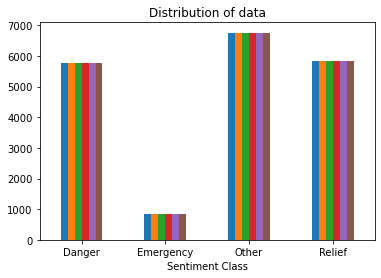

In [33]:
# Plotting the distribution for dataset.
ax = hurricanes.groupby('class_label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Danger','Emergency', 'Other', 'Relief'], rotation=0)
ax.set_xlabel('Sentiment Class')

In [34]:
#Creating a function to create word clouds out of the text belonging to the four classes
def create_wordcloud(sentiment, color):
    sent_class = hurricanes['processed_tweet'].loc[hurricanes['class_label'] == sentiment]

    sentiment_words = []
    for i in sent_class:
        listToStr = ' '.join(map(str, i))
        sentiment_words.append(listToStr)
    sentiment_words = ' '.join(map(str,  sentiment_words))

    # instantiate a word cloud object
    wc = WordCloud(
        background_color='white',
        max_words=2000,
        colormap=color
        )
    # generate the word cloud
    wc.generate(sentiment_words)

    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

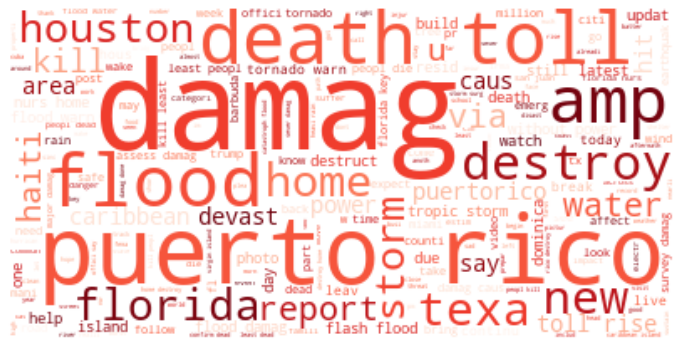

In [36]:
create_wordcloud('danger', 'Reds')

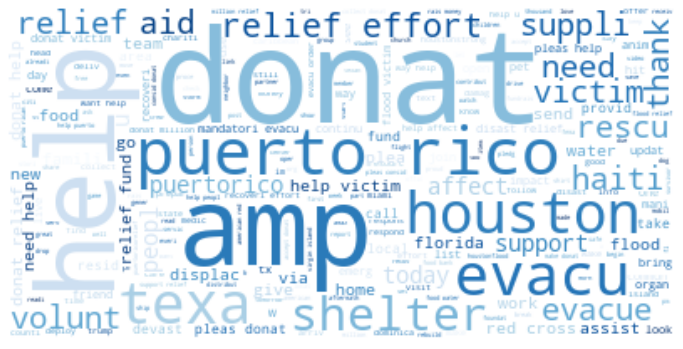

In [37]:
create_wordcloud('relief', 'Blues')

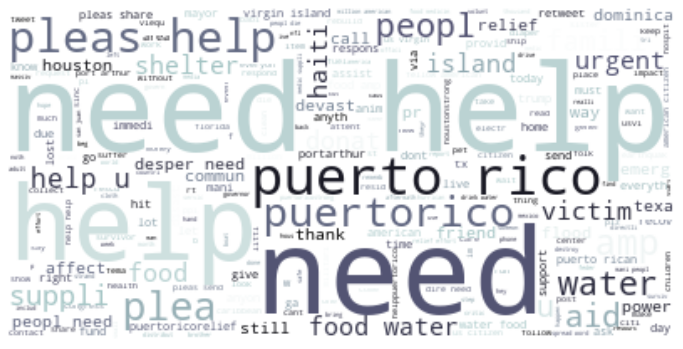

In [38]:
create_wordcloud('emergency', 'bone')

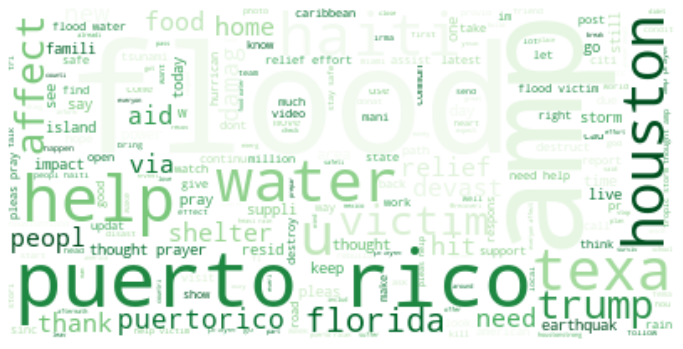

In [39]:
create_wordcloud('other', 'Greens')

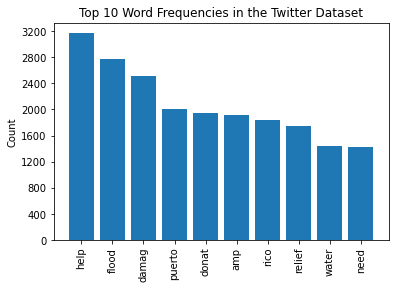

In [40]:
#Visualizing the word Frequency of the fully processed dataset
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
freq_dist = FreqDist(hurricanes['processed_tweet'].explode())

# Plot the top 10 tokens
visualize_top_10(freq_dist, "Top 10 Word Frequencies in the Twitter Dataset")

# Modeling

In [41]:
#Performing a train test split. The model_text column will be used here.
X = hurricanes.drop('label', axis=1)
y = hurricanes['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .8)

In [42]:
X_train

,tweet_id,tweet_text,class_label,processed_tweet,model_text,model_text_lemma
2905,912282180553969664,Naval vessels and aircraft were already in act...,relief,"[naval, vessel, aircraft, alreadi, action, rel...",Naval vessels and aircraft were already in act...,naval vessel and aircraft be already in action...
4658,907350424402919424,FPL nuclear facilities weathered Irma without ...,danger,"[fpl, nuclear, facil, weather, without, sustai...",FPL nuclear facilities weathered Irma without ...,fpl nuclear facility weather irma without sust...
121,903706274935717888,Nearly 200 Houston police officers have lost t...,danger,"[nearli, houston, polic, offic, lost, home]",Nearly 200 Houston police officers have lost t...,nearly 200 houston police officer have lose th...
1635,912165154405666816,"Fellow Citizens Here Neighbors Abroad, IN NEED...",other,"[fellow, citizen, neighbor, abroad, need, ever...","Fellow Citizens Here Neighbors Abroad, IN NEED...",fellow citizens here neighbors abroad in need ...
4075,910571399399559168,Mind-boggling damage reported in #Dominica fro...,danger,"[mind, boggl, damag, report, dominica, cat, ma...",Mind-boggling damage reported in Dominica from...,mind-boggling damage report in dominica from c...
...,...,...,...,...,...,...
6089,903454419366416384,Hurricane Harvey: Death toll reaches 38 as Tex...,danger,"[death, toll, reach, texa, louisiana, wit, exp...",Hurricane Harvey: Death toll reaches 38 as Tex...,hurricane harvey death toll reach 38 a texas l...
933,783405550054862848,Please do all you can to help!,emergency,"[pleas, help]",Please do all you can to help!,please do all you can to help
23,914205589047259136,.@USArmy #soldiers of the 602nd ASMC @FtBraggN...,other,"[soldier, nd, asmc, return, usvi, provid, medi...",. soldiers of the 602nd ASMC return to USVI t...,soldier of the 602nd asmc return to usvi to pr...
3418,903463236183498752,Dont touch me. Im dying. Harrowing Hurricane H...,other,"[dont, touch, im, die, harrow, stori, emerg]",Dont touch me. Im dying. Harrowing Hurricane H...,dont touch me im dying harrowing hurricane har...


# Baseline Model Dummy Classifier

In [43]:
dum_pipe = Pipeline([('count', CountVectorizer()),
                    ('model', DummyClassifier(strategy='stratified'))])

model = dum_pipe.fit(X_train['model_text'], y_train)

y_trn_pred = dum_pipe.predict(X_train['model_text'])
y_tst_pred = dum_pipe.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      4609
           1       0.06      0.06      0.06       685
           2       0.35      0.36      0.35      5408
           3       0.30      0.30      0.30      4664

    accuracy                           0.31     15366
   macro avg       0.25      0.25      0.25     15366
weighted avg       0.31      0.31      0.31     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.29      0.28      0.29      1153
           1       0.06      0.06      0.06       171
           2       0.36      0.36      0.36      1352
           3       0.30      0.31      0.31      1166

    accuracy                           0.31      3842
   macro avg       0.25      0.25      0.25      3842
weighted avg       0.31      0.31      0.31      3842



# Simple Model: Logistic Regression

In [45]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('lr', LogisticRegression()),
])

lr_model = lr_pipe.fit(X_train['model_text'], y_train)
    
y_trn_pred = lr_model.predict(X_train['model_text'])
y_tst_pred = lr_model.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))
print('Test Score: ', lr_model.score(X_test['model_text'], y_test))
cv_score = cross_val_score(lr_model, X_train['model_text'], y_train)
print('Cross Validation Score: ', cv_score.mean())


/Users/brettzimmerman/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


		The Train Results
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4609
           1       0.65      0.94      0.77       685
           2       0.89      0.85      0.87      5408
           3       0.91      0.90      0.91      4664

    accuracy                           0.89     15366
   macro avg       0.84      0.90      0.86     15366
weighted avg       0.89      0.89      0.89     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1153
           1       0.47      0.70      0.56       171
           2       0.76      0.74      0.75      1352
           3       0.82      0.79      0.81      1166

    accuracy                           0.79      3842
   macro avg       0.73      0.77      0.75      3842
weighted avg       0.80      0.79      0.79      3842

Test Score:  0.7904737116085372


/Users/brettzimmerman/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/brettzimmerman/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Cross Validation Score:  0.7790579100910591


/Users/brettzimmerman/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Gridsearch on a Logistic Regression Model

In [49]:
tf_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('lr', LogisticRegression()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.75),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1, 1),(1, 2)],
    'tfidf__max_features': (8000, 10000, 70000),
    'lr__C': (.7, 1, 1.5),
    'lr__class_weight' : (['balanced']),
    'lr__solver': ('newton-cg', 'sag', 'saga', 'lbfgs'),
    'lr__max_iter': (100, 200, 300),
    'smt__k_neighbors' : (2, 5)
}

grid_search = GridSearchCV(tf_lr_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = 'f1_macro')
grid_search.fit(X_train['model_text'], y_train)

tf_lr_best = grid_search.best_estimator_

y_trn_pred = tf_lr_best.predict(X_train['model_text'])
y_tst_pred = tf_lr_best.predict(X_test['model_text'])

print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 1728 candidates, totalling 3456 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  9.5min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 18.6min
[Parallel(n_jobs=2)]: Done 2044 tasks      | elapsed: 23.9min
[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed: 29.0min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 36.2min
[Parallel(n_jobs=2)]: Done 3456 out of 3456 | elapsed: 39.5min finished


		The Train Results
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4609
           1       0.65      0.95      0.77       685
           2       0.88      0.83      0.86      5408
           3       0.90      0.90      0.90      4664

    accuracy                           0.88     15366
   macro avg       0.84      0.90      0.86     15366
weighted avg       0.89      0.88      0.88     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1153
           1       0.49      0.71      0.58       171
           2       0.76      0.73      0.74      1352
           3       0.82      0.81      0.81      1166

    accuracy                           0.79      3842
   macro avg       0.73      0.77      0.75      3842
weighted avg       0.79      0.79      0.79      3842



In [50]:
#Saving the best parameters according to the gridsearch
tf_lr_best

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, max_features=8000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x17a22bee0>)),
                ('smt', SMOTE(random_state=30)),
                ('lr',
                 LogisticRegression(C=1, class_weight='balanced',
       

# Grid Search on MultinomialNB Classifier

In [46]:
tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('mnb', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.75),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1, 1),(1, 2)],
    'tfidf__max_features': (8000, 10000, 70000),
    'mnb__alpha': (.05, .5, 2),
    'smt__k_neighbors' : (2, 5)
}

grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = 'f1_macro')
grid_search.fit(X_train['model_text'], y_train)

tf_nb_best = grid_search.best_estimator_

y_trn_pred = tf_nb_best.predict(X_train['model_text'])
y_tst_pred = tf_nb_best.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 288 out of 288 | elapsed:  1.6min finished


		The Train Results
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4609
           1       0.48      0.96      0.64       685
           2       0.86      0.69      0.77      5408
           3       0.83      0.85      0.84      4664

    accuracy                           0.81     15366
   macro avg       0.75      0.85      0.78     15366
weighted avg       0.83      0.81      0.81     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1153
           1       0.36      0.77      0.49       171
           2       0.72      0.58      0.64      1352
           3       0.77      0.77      0.77      1166

    accuracy                           0.72      3842
   macro avg       0.66      0.73      0.68      3842
weighted avg       0.73      0.72      0.72      3842



In [47]:
#Saving the best parameters according to the gridsearch
tf_nb_best

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, max_features=8000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x17a22bee0>)),
                ('smt', SMOTE(k_neighbors=2, random_state=30)),
                ('mnb', MultinomialNB(alpha=0.5))])

# Trying the best nb parameters on a model using text cleaned with lemmatization

In [48]:
lemma_model = tf_nb_best.fit(X_train['model_text_lemma'], y_train)
    
y_trn_pred = lemma_model.predict(X_train['model_text_lemma'])
y_tst_pred = lemma_model.predict(X_test['model_text_lemma'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))
print('Test Score: ', tf_nb_best.score(X_test['model_text_lemma'], y_test))
cv_score = cross_val_score(tf_nb_best, X_train['model_text_lemma'], y_train)
print('Cross Validation Score: ', cv_score.mean())


		The Train Results
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4609
           1       0.47      0.95      0.63       685
           2       0.86      0.69      0.77      5408
           3       0.84      0.85      0.85      4664

    accuracy                           0.81     15366
   macro avg       0.75      0.84      0.77     15366
weighted avg       0.83      0.81      0.81     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1153
           1       0.35      0.74      0.48       171
           2       0.73      0.58      0.64      1352
           3       0.76      0.77      0.76      1166

    accuracy                           0.72      3842
   macro avg       0.65      0.73      0.67      3842
weighted avg       0.74      0.72      0.72      3842

Test Score:  0.7188964081207704
Cross Validation Score:  0.718990277991557


# Creating a function to test out models with my own text input

In [50]:
def predict(pipeline, text):
    # Predict the sentiment
    #textdata = pipeline.transform()
    text = [remove_junk(i) for i in text]
    sentiment = pipeline.predict(text)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1,2,3], ['danger', 'emergency', 'other', 'relief'])
    return df

In [129]:
tweets = ["Direct Relief Commits $25 Million in Medical Supplies to Hurricane Sandy Recovery Efforts  http://t.co/sxiYBtKl", "Im gonna die here", "6 stranded on park and main it is desperate", "i love me a good cane"]
predictions = predict(tf_nb_best, tweets)
print(predictions)

                                                text  sentiment
0  Direct Relief Commits $25 Million in Medical S...     relief
1                                  Im gonna die here     danger
2        6 stranded on park and main it is desperate  emergency
3                              i love me a good cane      other


# Into More Advanced Models...

In [160]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

RuntimeError: variable_scope module_2/ was unused but the corresponding name_scope was already taken.

In [161]:
# just a random sentence
x = ["Roasted ants are a popular snack in Columbia"]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

embeddings.shape

TypeError: 'AutoTrackable' object is not callable

In [2]:
!pip install transformers
!pip install torch

     |████████████████████████████████| 2.8 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 74.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 54.2 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 26.7 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

huggingface-hub 0.0.16 requires packaging>=20.9, but you'll have packaging 20.4 which is incompatible.
     |████████████████████████████████| 127.9 MB 59.4 MB/s eta 0:00:01


In [11]:
pip install sentencepiece

     |████████████████████████████████| 1.1 MB 3.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install transformers==2.9.0 

     |████████████████████████████████| 635 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 52.9 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3


In [42]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch


import seaborn as sns
from matplotlib import rc
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [43]:
from transformers import XLNetTokenizer
xltokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
input_txt = "i want to go to play in the store"
encodings = xltokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)

In [44]:
xltokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '▁',
 'i',
 '▁want',
 '▁to',
 '▁go',
 '▁to',
 '▁play',
 '▁in',
 '▁the',
 '▁store',
 '<sep>',
 '<cls>']

In [76]:
from keras.preprocessing.sequence import pad_sequences
input_txt = "Input text goes here"
encodings = xltokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")
input_ids = pad_sequences(encodings['input_ids'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [77]:
class HurricaneDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [78]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [79]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = HurricaneDataset(
        reviews=df.tweet_text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=xltokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [80]:
df_train, df_test = train_test_split(hurricanes, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [81]:
BATCH_SIZE = 4
MAX_LEN = 512

train_data_loader = create_data_loader(df_train, xltokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, xltokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, xltokenizer, MAX_LEN, BATCH_SIZE)

In [82]:
#df_train.drop(['tweet_id', 'class_label', 'processed_tweet', 'model_text', 'model_text_lemma'], axis=1)
#df_test.drop(['tweet_id', 'class_label', 'processed_tweet', 'model_text', 'model_text_lemma'], axis=1)
#df_val.drop(['tweet_id', 'class_label', 'processed_tweet', 'model_text', 'model_text_lemma'], axis=1)

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

In [85]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [92]:
EPOCHS = 1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [89]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(4,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [90]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [93]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/1
----------


KeyboardInterrupt: 